In [285]:
#importamos las librerias necesarias para la realización del proyecto

import tensorflow as tf #librería utilizada para la creación de modelos de aprendizaje automático
import tensorflow_datasets as tfds #nos da acceso a los datasets preparados para el uso con tensorflow
import matplotlib.pyplot as plt #librería que nos permite visualizar imagenes
import math #para usar ecuaciones matematicas
import numpy as np #librería para poder trabajar con matrices
import cv2 as cv #nos facilita el tratar con imagenes

---
### Preparar los datos

In [286]:
#Descargamos el set de datos pneumonia_mnist
datos, metadatos = tfds.load('pneumonia_mnist', as_supervised=True, with_info=True)

In [287]:
#vemos la información del set de datos
metadatos

tfds.core.DatasetInfo(
    name='pneumonia_mnist',
    full_name='pneumonia_mnist/1.0.0',
    description="""
    # MedMNIST Pneumonia Dataset
    
    The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray
    images. The task is binary-class classification of pneumonia against normal. The
    source training set is split with a ratio of 9:1 into training and validation
    set, and use its source validation set as the test set. The source images are
    gray-scale, and their sizes are (384–2,916) × (127–2,713). The images are
    center-cropped with a window size of length of the short edge and resized into 1
    × 28 × 28.
    """,
    homepage='https://medmnist.com//',
    data_dir='/root/tensorflow_datasets/pneumonia_mnist/1.0.0',
    file_format=tfrecord,
    download_size=3.98 MiB,
    dataset_size=3.66 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),

In [288]:
#podemos ver que se tienen 624 datos para probar, 4708 para entrenar y 524 datos para validar
#separamos cada datos en variables para utilizarlas por separado
datos_entrenamiento, datos_pruebas, datos_validacion = datos['train'], datos['test'], datos["val"]

In [289]:
#miramos las clasificaciones que hay en el set de datos
nombres_clases = metadatos.features['label'].names
nombres_clases

['Normal', 'Pneumonia']

In [290]:
#Normalizar los datos hace que la red aprenda mejor y más rapido
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)#convertimos a tipo float para su uso
  imagenes /= 255 #pasamos de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizar los datos con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)
datos_validacion = datos_validacion.map(normalizar)

#Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

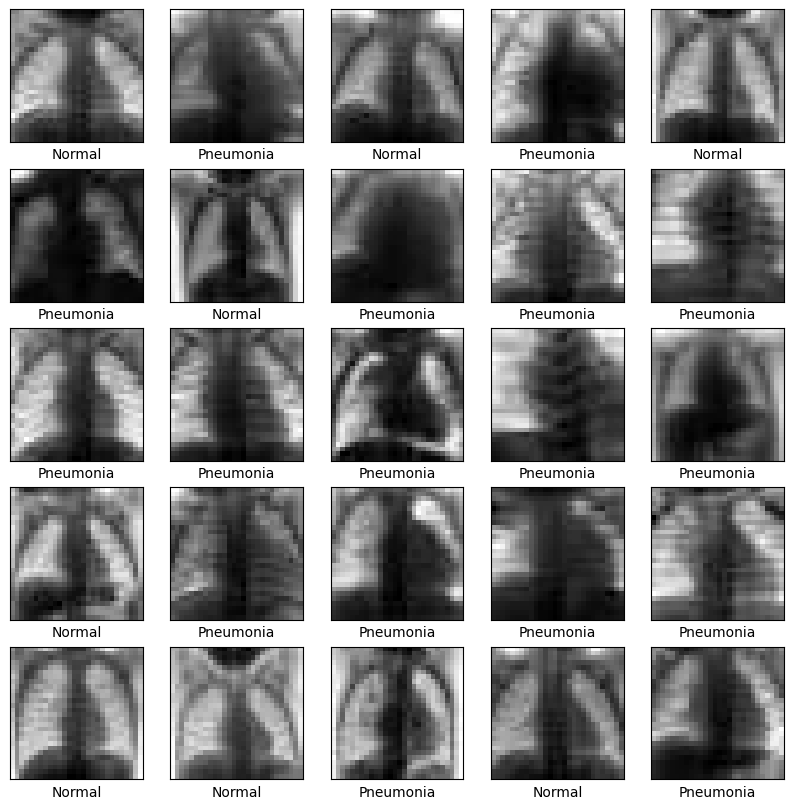

In [291]:
#Probamos que todo funcione correctamente mostrando imagenes del dataset
plt.figure(figsize=(10,10)) #cambiamos el tamaño de las imagenes para mostrar varias

for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)): #usamos 25 ejemplos
  imagen = imagen.numpy().reshape((28,28))#redimencionamos y la convierte en un array de numpy
  plt.subplot(5,5,i+1) #muestra las imagenes en un cuadro de 5X5
  plt.xticks([]) #quitamos los ejes para que no se miren
  plt.yticks([])
  plt.grid(False) #desactivamos la cuadricula
  plt.imshow(imagen, cmap=plt.cm.binary) #pone la imagen en escala de grises
  plt.xlabel(nombres_clases[etiqueta]) #muestra las eqtiquetas de cada imagen
plt.show() #mostramos las imagenes

---
### Entrenamiento del modelo

In [305]:
#Crear el modelo
#usamos una red de tipo secuencial
modelo = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28,1)), #flatten pasa a una sola dimension
  #capas ocultas
  tf.keras.layers.Dense(70, activation=tf.nn.relu), #usamos la función de activación de relu
  tf.keras.layers.Dense(45, activation=tf.nn.relu),
  #tenemos dos salidas
  tf.keras.layers.Dense(2, activation=tf.nn.softmax) #Softmax para redes de clasificación, así vemos que la suma en la salida sea siempre 1

])

In [306]:
#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [294]:
#ya que son varios datos usaremos lotes para poder entrenar una gran cantidad de datos

#guardamos el número de datos que tenemos de prueba y de entrenamiento
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples
num_ej_validacion = metadatos.splits["val"].num_examples

In [295]:
#confirmamos cuantos datos hay
print(num_ej_entrenamiento)
print(num_ej_pruebas)
print(num_ej_validacion)

4708
624
524


In [296]:
lote = 32
#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red no se aprenda el orden de las cosas
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(lote)
datos_pruebas = datos_pruebas.batch(lote)
datos_validacion = datos_validacion.batch(lote)

In [307]:
#Entrenar la red
historial = modelo.fit(datos_entrenamiento, epochs=160, steps_per_epoch= math.ceil(num_ej_entrenamiento/lote), validation_data= datos_validacion, validation_steps=math.ceil(num_ej_validacion / lote))

Epoch 1/160
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7837 - loss: 0.4451 - val_accuracy: 0.9179 - val_loss: 0.2048
Epoch 2/160
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9101 - loss: 0.2091 - val_accuracy: 0.9542 - val_loss: 0.1564
Epoch 3/160
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9381 - loss: 0.1573 - val_accuracy: 0.9466 - val_loss: 0.1520
Epoch 4/160
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9486 - loss: 0.1435 - val_accuracy: 0.9561 - val_loss: 0.1377
Epoch 5/160
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9330 - loss: 0.1576 - val_accuracy: 0.9523 - val_loss: 0.1374
Epoch 6/160
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9387 - loss: 0.1393 - val_accuracy: 0.9466 - val_loss: 0.1549
Epoch 7/160
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9381 - loss: 0.1399 - val_accuracy: 0.9542 - val_loss: 0.1345
Epoch 8/160
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9524 - loss: 0.1327 - val_accu

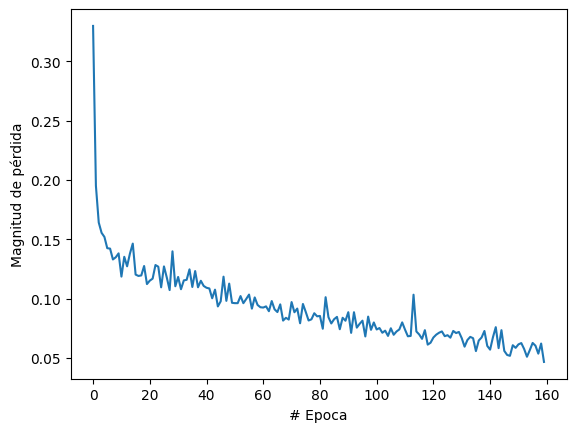

In [313]:
#Ver la funcion de perdida
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

---
### Procesar imagenes


In [299]:
# guardar modelo
modelo.save("modelo_pneumonia.keras")

In [300]:
# Función para preprocesar la imagen
def preprocesar_imagen(ruta_imagen):
    imagen = cv.imread(ruta_imagen, cv.IMREAD_GRAYSCALE)  # Cargar en escala de grises
    imagen = cv.resize(imagen, (28, 28))  # Redimensionar a 28x28
    imagen = imagen / 255.0  # Normalizar a valores entre 0 y 1
    imagen = np.expand_dims(imagen, axis=-1)  # Añadir dimensión de canal
    imagen = np.expand_dims(imagen, axis=0)  # Añadir dimensión de batch
    return imagen

In [301]:
# Función para hacer la predicción
def predecir_neumonia(ruta_imagen):
    imagen_procesada = preprocesar_imagen(ruta_imagen) #preprocesamos las imagenes para ingresarlas al modelo
    prediccion = modelo.predict(imagen_procesada) #usamos el modelo entrenado para clasificar las imagenes
    clase = np.argmax(prediccion)  # 0: Normal, 1: Neumonía
    resultado = "Neumonía" if clase == 1 else "Normal"
    return resultado

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Resultado del análisis: Normal


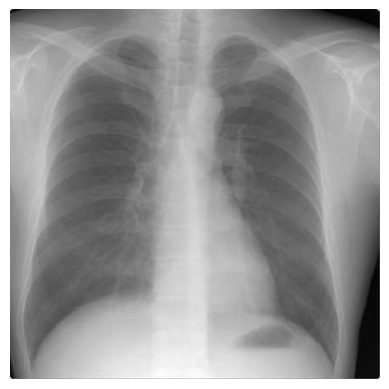

In [312]:
# Ruta de la imagen a analizar
ruta_imagen = "/content/ImagenesTest/chest-xray.jpg"
resultado = predecir_neumonia(ruta_imagen) #analizamos la imagen para clasificarla
print(f"Resultado del análisis: {resultado}")#mostramos el resultado

#leemos la imagen
imagen = cv.imread(ruta_imagen, cv.IMREAD_GRAYSCALE)

# Mostrar la imagen con Matplotlib
plt.imshow(imagen, cmap='gray')  # Mostrar en escala de grises
plt.axis("off")  # Ocultar ejes
plt.show()